In [1]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import torch
from torch.utils.data import random_split,DataLoader,TensorDataset
from PIL import Image
import torchvision
import os
import random
from torchvision import models,transforms,datasets
from torchvision.models import ResNet18_Weights

### Actividad de CNN

Nota: aplicamos data augmentation para las clases queen y pawn, las cuales son las clases de menor tamaño en el dataset

In [2]:
transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [3]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        
        # Si la clase es 2 o 3, aplica aumento especial
        if target in [2, 3]:
            sample = transform_augmented(sample)
        else:
            sample = transform_base(sample)
        
        return sample, target


In [4]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

path = "pieces"

dataset = datasets.ImageFolder(path,transform=transform)
train_dataset = CustomImageFolder(path)

train_set,val_set,test_set = random_split(train_dataset,[400-1,125,126],generator=torch.Generator().manual_seed(619))

val_set.dataset.transform = transform_base
test_set.dataset.transform = transform_base

train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
val_loader = DataLoader(val_set,batch_size=32,shuffle=False)
test_loader = DataLoader(test_set,batch_size=32,shuffle=False)   

En el siguiente bloque explore la data, con el fin de responder a estas preguntas.  
- ¿De que se trata el dataset?
- ¿Cuales son las clases de salida?
- ¿Cuantas imagenes hay por clase?
- ¿Cual es el tamaño de las imagenes?
- ¿Cuantas imagenes hay en total?
- Grafique algunas imagenes de cada clase
- etc.

In [5]:
#Para mostrar X imagenes aleatorias
X = 5
indices = random.sample(range(len(dataset)), X)
print(indices)

[184, 29, 488, 324, 627]


Clases: ['bishop', 'knight', 'pawn', 'queen', 'rook']
{'bishop': 0, 'knight': 1, 'pawn': 2, 'queen': 3, 'rook': 4}

Cantidad de imagenes: 650
Cantidad de alfiles : 141
Cantidad de Caballos : 174
Cantidad de Peones : 81
Cantidad de Reinas : 115
Cantidad de Torre : 139

Ya que se redimensionaron las imagenes a 224x244 en transform, todas las imagenes tendrán ese tamaño
torch.Size([3, 224, 224])

Total de imágenes: 650


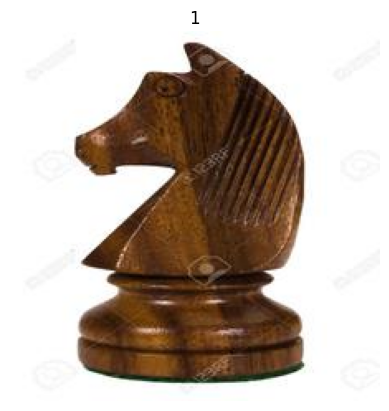

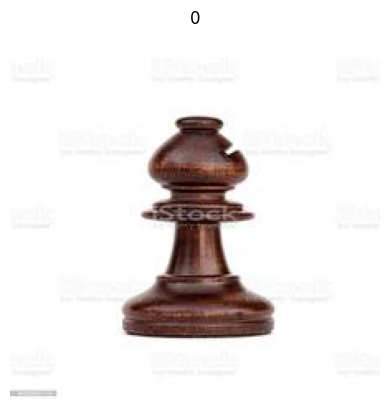

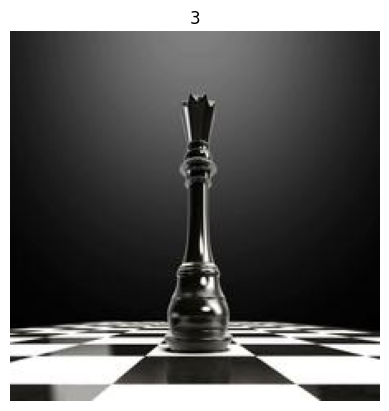

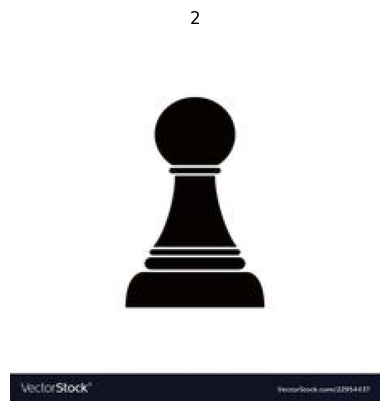

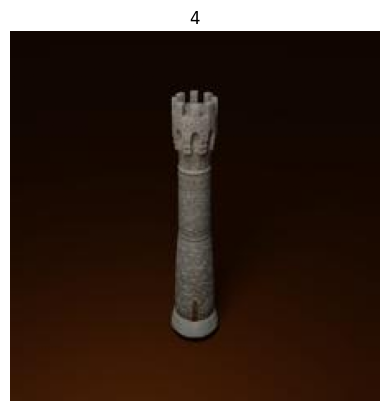

In [6]:
""" De que trata el dataset? """
# Viendo la carpeta de las imagenes, podemos observar que se tienen diferentes carpetas en las que se encuentran
# imagenes de diferentes piezas de ajegrez, como lo son alfil, caballo, peon, reina y torre.

""" Cuales son las clases? """
print(f"Clases: {dataset.classes}")

""" Cuantas imagenes hay por clase """
print(dataset.class_to_idx)
print(f"\nCantidad de imagenes: {len(dataset)}")
print(f"Cantidad de alfiles : {dataset.targets.count(0)}")
print(f"Cantidad de Caballos : {dataset.targets.count(1)}")
print(f"Cantidad de Peones : {dataset.targets.count(2)}")
print(f"Cantidad de Reinas : {dataset.targets.count(3)}")
print(f"Cantidad de Torre : {dataset.targets.count(4)}")

""" Cuál es el tamaño de las imágenes? """
print("\nYa que se redimensionaron las imagenes a 224x244 en transform, todas las imagenes tendrán ese tamaño")
img,_ = dataset[384]
print(img.shape)

""" Cuántas imágenes hay en total? """
print("\nTotal de imágenes:", len(dataset))
# Originalmente eran 651 imagenes, pero debimos eliminar una la cual su contenido era simplemente una imagen en negro, 
# lo cual podría perjudicar el aprendizaje del modelo

""" Grafique algunas imagenes de cada clase """
for i in indices:
    img,idx = dataset[i]
    plt.imshow(img.permute(1,2,0))
    plt.title(idx)
    plt.axis("off")
    plt.show()

En el siguiente bloque implemente el modelo que le permitirá clasificar las diferentes tipos de piezas en el ajedrez, justifique la arquitectura de la red.

In [7]:
from torchvision.models import resnet18, ResNet18_Weights


class ModelResNetMate(nn.Module):

    def __init__(self, num_classes=5):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.model = resnet18(weights=weights)

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

**Justificación**

Se decidió por utilizar una red pre-entrenada de ResNet18 para el problema de clasificación de piezas de ajedrez, esta es una red profunda de 18 capas, de las cuales una de ellas es una capa completamente conectada. Destacada por su diseño en bloques residuales que ayudan a resolver el problema de gradiente que se desvanece (común en redes profundas), siendo robusta en tareas de clasificación general sobre el conjunto ImageNet, lo que la convierte en una buena base para tareas similares como esta.

En el siguiente bloque cree una instancia de su red neuronal convolucional definida anteriormente y defina una función de perdida y un optimizador.	

In [8]:
# Cargar modelo preentrenado
model =  ModelResNetMate() # .resnet18(pretrained=True) 

# Solo entrenaremos la última capa (fully connected - fc)
for param in model.parameters():
    param.requires_grad = False # Congelamos el resto
for param in model.model.fc.parameters():
    param.requires_grad = True # Activamos el gradiente para la última capa

In [9]:
class_counts = np.bincount(dataset.targets)
weights = 1. / torch.tensor(class_counts, dtype=torch.float)

criterion = nn.CrossEntropyLoss() # Para la clasificacion de las 5 clases
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4) # Optimizador que ajusta automaticamente el learning rate

# Weight_decay es un hiperparámetro para regularizar el modelo y evitar un sobreajuste 
# Es una forma de penalizar los pesos grandes durante el entrenamiento y que el modelo se mantenga a generalizar datos nuevos
# Lo usamos ya que probamos con un modelo anteriormente que tenía este problema, y al usarlo con el nuevo modelo mostró una
# mejora en las métricas, por lo que decidimos mantenerlo.

En el siguiente bloque programe el entrenamiento de su red neuronal convolucional.

In [10]:
num_epoch = 20
running_loss = np.zeros(shape=(num_epoch, 2)) # Para almacenar las perdidas promedio en train y val


for i in range(num_epoch):
    train_loss, valid_loss = 0.0, 0.0 # Para calcular la perdida por época

     # ---- Entrenamiento ----
    model.train()
    for img,index in train_loader:
        outputs = model(img) # Predicción
        loss = criterion(outputs,index)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 

    # ---- Validación (Accuracy) ----
    model.eval()
    for img,index in val_loader:
        with torch.no_grad(): # no cálculamos gradiente para validación
            outputs = model(img)
            loss = criterion(outputs,index)
            valid_loss += loss.item()
    

    # -----------------------------------

    # Calculamos la perdida promedio por epoca (ya que cada batch tiene su propia perdida)
    avg_train_loss = train_loss/len(train_loader.dataset)
    avg_valid_loss = valid_loss/len(val_loader.dataset)
    running_loss[i] = avg_train_loss, avg_valid_loss
    
    print(f"Epoch [{i+1}/{num_epoch}], Loss: {loss.item():.4f}")


Epoch [1/20], Loss: 1.2488
Epoch [2/20], Loss: 1.0191
Epoch [3/20], Loss: 0.8928
Epoch [4/20], Loss: 0.7933
Epoch [5/20], Loss: 0.7046
Epoch [6/20], Loss: 0.6654
Epoch [7/20], Loss: 0.6053
Epoch [8/20], Loss: 0.5602
Epoch [9/20], Loss: 0.5426
Epoch [10/20], Loss: 0.5506
Epoch [11/20], Loss: 0.5111
Epoch [12/20], Loss: 0.4827
Epoch [13/20], Loss: 0.4640
Epoch [14/20], Loss: 0.4620
Epoch [15/20], Loss: 0.4539
Epoch [16/20], Loss: 0.4875
Epoch [17/20], Loss: 0.4446
Epoch [18/20], Loss: 0.4498
Epoch [19/20], Loss: 0.4164
Epoch [20/20], Loss: 0.4329


En el siguiente bloque muestre el gráfico de entrenamiento y validación de su red neuronal convolucional.

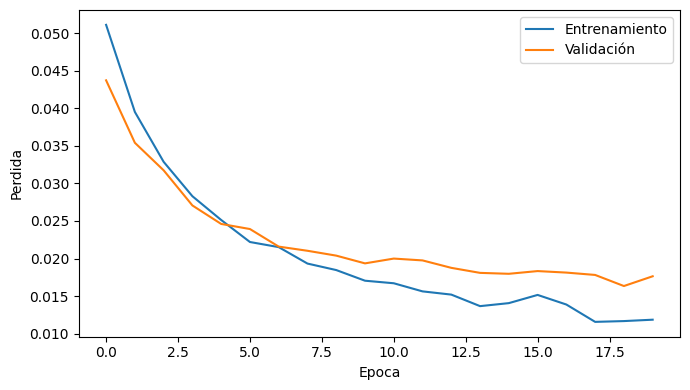

In [11]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:, 0], label='Entrenamiento')
ax.plot(running_loss[:, 1], label='Validación')
ax.set_xlabel('Epoca')
ax.set_ylabel('Perdida')
ax.legend()

Muestre diferentes métricas de evaluación de su red neuronal convolucional.

METRICAS EN TEST
Accuracy:  80.95%
Precision: 80.88%
Recall:    80.95%
F1 Score:  80.77%



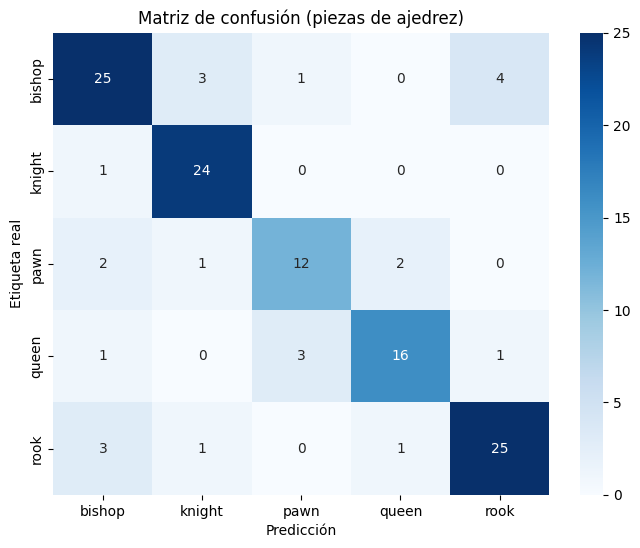

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

correct = 0
total = 0
# Recolectar todas las predicciones y etiquetas verdaderas
all_preds = []
all_index = []

model.eval()
with torch.no_grad():
   for img,index in test_loader:
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        total += index.size(0)
        correct += (predicted == index).sum().item()
        all_preds.extend(predicted.numpy())
        all_index.extend(index.numpy())

print("METRICAS EN TEST")
acc = accuracy_score(all_index, all_preds)
prec = precision_score(all_index, all_preds, average='weighted')
rec = recall_score(all_index, all_preds, average='weighted')
f1 = f1_score(all_index, all_preds, average='weighted')
print(f"Accuracy:  {acc:.2%}")
print(f"Precision: {prec:.2%}")
print(f"Recall:    {rec:.2%}")
print(f"F1 Score:  {f1:.2%}\n")

# Nombres de las clases según su orden numérico
class_names = ['bishop', 'knight', 'pawn', 'queen', 'rook']

# Calcular matriz de confusión
cm = confusion_matrix(all_index, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión (piezas de ajedrez)")
plt.show()


Concluya sobre las métricas obtenidas y el entrenamiento de su red neuronal convolucional.

### **Análisis de métricas**
Despues de probar varios ajustes con el modelo, como añadir data augmention (para las clases queen y pawn, las cuales el modelo tenía dificultades para predecir, esto quizá por ser las clases con menor tamaño), también Weight_decay y balance de datos, logramos obtener los siguientes resultados en test:

* **Accuracy (80.95%)**

El 80.95% de las imágenes fueron clasificadas correctamente en su clase real, lo que indica un buen desempeño general en la tarea de reconocimiento de piezas de ajedrez.

* **Precision (80.88%)**

De todas las predicciones hechas por el modelo el 82.02% fueron correctas, reflejando una baja tasa de falsos positivos.

* **Recall (80.95%)**

El modelo logró correctamente un 81.75% que las imágenes realmente pertenecían a una clase, mostrando una buena sensibilidad, es decir, logró identificar varios ejemplos verdaderos de cada clase, incluso sin olvidarse de clases específicas cómo pawn o queen.

* **F1 Score (80.77%)**
  
El modelo logró un buen balance entre precisión y recall, siendo > 80% por lo que nos indica que logró ser muy bueno en generalización.

### **Matriz de confusión**
Podemos observar que el modelo logró predecir correctamente la mayoria de imagenes, notando que el modelo se confunde principalmente entre queen y pawn, lo cual tiene sentido debido a que tienen una forma algo similar. Por otro lado, podemos observar que logró predecir correctamente la mayoria de imagenes en bishop y rook pero sigue confundiendose con varias otras piezas, esto quizá debido a que el modelo pueda verse confundido por otros detalles cómo el color.

### **Conclusión entrenamiento del modelo**
El entrenamiento del modelo demostró una buena curva de aprendizaje, pues observando el gráfico, notamos que la pérdida disminuye de forma constante mientras avanzan las epocas, esto indica que el modelo logró aprender correctamente las representaciones necesarias para clasificar las piezas de ajedrez. Eso si, de la validación, podemos observar que su curva deja de mejorar un poco, sugiriendo un sobreajuste leve, el cual logró ser controlado ya que se mantiene en un rango razonable.

En el siguiente bloque muestre las predicciones de su red neuronal convolucional y responda:
- ¿Cree que los errores son razonables?
- ¿Qué haría para mejorar la clasificación de las piezas de ajedrez?


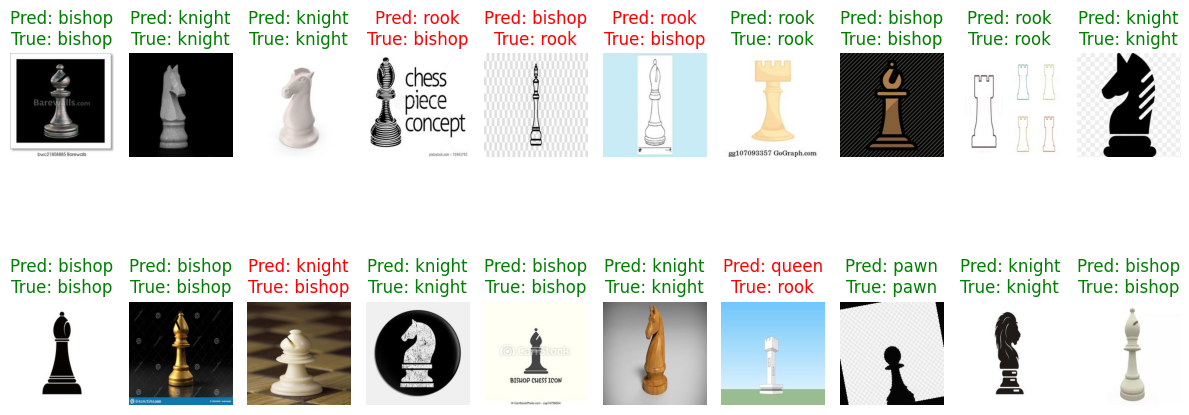

In [13]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(test_loader)
images, labels = next(dataiter)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

class_names = dataset.classes

# Mostrar 6 imágenes
fig, axs = plt.subplots(2, 10, figsize=(12, 6))
axs = axs.flatten()

for i in range(20):
    img = images[i].permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # ← desnormalizar si normalizaste con mean=0.5, std=0.5

    axs[i].imshow(img)
    axs[i].set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}",
                     color='green' if preds[i] == labels[i] else 'red')
    axs[i].axis('off')

plt.tight_layout()
plt.show()